In [ ]:
# 2

# 1) 트랜스포머(Transformer)
- 이번 챕터는 앞서 설명한 어텐션 메커니즘 챕터에 대한 사전 이해가 필요합니다.

트랜스포머(Transformer)는 2017년 구글이 발표한 논문인 "Attention is all you need"에서 나온 모델로 기존의 seq2seq의 구조인 인코더-디코더를 따르면서도, 논문의 이름처럼 어텐션(Attention)만으로 구현한 모델입니다. 이 모델은 RNN을 사용하지 않고, 인코더-디코더 구조를 설계하였음에도 성능도 RNN보다 우수하다는 특징을 갖고있습니다.

**당장 구현에 관심이 없다면 코드 부분만 스킵해서 이론만 읽으셔도 됩니다.**

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## 1. 기존의 seq2seq 모델의 한계
트랜스포머에 대해서 배우기 전에 기존의 seq2seq를 상기해봅시다. 기존의 seq2seq 모델은 인코더-디코더 구조로 구성되어져 있었습니다. 여기서 인코더는 입력 시퀀스를 하나의 벡터 표현으로 압축하고, 디코더는 이 벡터 표현을 통해서 출력 시퀀스를 만들어냈습니다. 하지만 이러한 구조는 인코더가 입력 시퀀스를 하나의 벡터로 압축하는 과정에서 입력 시퀀스의 정보가 일부 손실된다는 단점이 있었고, 이를 보정하기 위해 어텐션이 사용되었습니다. 그런데 어텐션을 RNN의 보정을 위한 용도가 아니라 아예 어텐션으로 인코더와 디코더를 만들어보면 어떨까요?

 ## 2. 트랜스포머(Transformer)의 주요 하이퍼파라미터
시작에 앞서 트랜스포머의 하이퍼파라미터를 정의하고자 합니다. 각 하이퍼파라미터의 의미에 대해서는 뒤에서 설명하기로하고, 여기서는 트랜스포머에는 이러한 하이퍼파라미터가 존재한다는 정도로만 이해해보도록 하겠습니다. 아래에서 정의하는 수치값은 트랜스포머를 제안한 논문에서 사용한 수치값으로 하이퍼파라미터는 사용자가 모델 설계시 임의로 변경할 수 있는 값들입니다.

$d_{model}$ = 512 \
트랜스포머의 인코더와 디코더에서의 정해진 입력과 출력의 크기를 의미합니다. 임베딩 벡터의 차원 또한 $d_{model}$이며, 각 인코더와 디코더가 다음 층의 인코더와 디코더로 값을 보낼 때에도 이 차원을 유지합니다. 논문에서는 512입니다.

$\text{num_layers}$ = 6 \
트랜스포머에서 하나의 인코더와 디코더를 층으로 생각하였을 때, 트랜스포머 모델에서 인코더와 디코더가 총 몇 층으로 구성되었는지를 의미합니다. 논문에서는 인코더와 디코더를 각각 총 6개 쌓았습니다.

$\text{num_heads}$ = 8 \
트랜스포머에서는 어텐션을 사용할 때, 1번 하는 것 보다 여러 개로 분할해서 병렬로 어텐션을 수행하고 결과값을 다시 하나로 합치는 방식을 택했습니다. 이때 이 병렬의 개수를 의미합니다.

$d_{ff}$ = 2048 \
트랜스포머 내부에는 피드 포워드 신경망이 존재합니다. 이때 은닉층의 크기를 의미합니다. 피드 포워드 신경망의 입력층과 출력층의 크기는 $d_{model}$입니다.

## 3. 트랜스포머(Transformer)

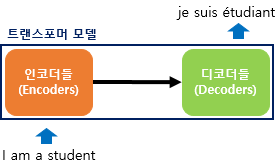

트랜스포머는 RNN을 사용하지 않지만 기존의 seq2seq처럼 인코더에서 입력 시퀀스를 입력받고, 디코더에서 출력 시퀀스를 출력하는 인코더-디코더 구조를 유지하고 있습니다. 다만 다른 점은 인코더와 디코더라는 단위가 N개가 존재할 수 있다는 점입니다.

이전 seq2seq 구조에서는 인코더와 디코더에서 각각 하나의 RNN이 t개의 시점(time-step)을 가지는 구조였다면 이번에는 인코더와 디코더라는 단위가 N개로 구성되는 구조입니다. 트랜스포머를 제안한 논문에서는 인코더와 디코더의 개수를 각각 6개를 사용하였습니다.

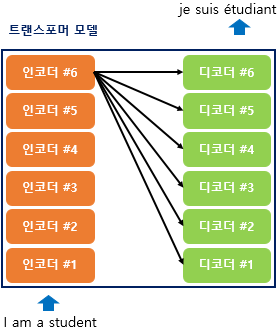

위의 그림은 인코더와 디코더가 6개씩 존재하는 트랜스포머의 구조를 보여줍니다. 이 책에서는 인코더와 디코더가 각각 여러 개 쌓여있다는 의미를 사용할 때는 알파벳 s를 뒤에 붙여 encoders, decoders라고 표현하겠습니다.

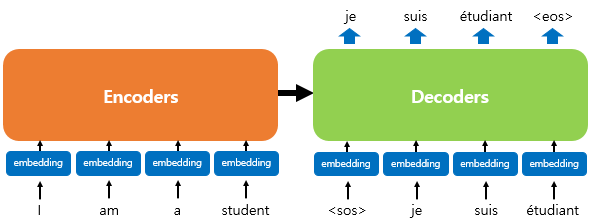

위의 그림은 인코더로부터 정보를 전달받아 디코더가 출력 결과를 만들어내는 트랜스포머 구조를 보여줍니다. 디코더는 마치 기존의 seq2seq 구조처럼 시작 심볼 $<sos>$를 입력으로 받아 종료 심볼 $<eos>$가 나올 때까지 연산을 진행합니다. 이는 RNN은 사용되지 않지만 여전히 인코더-디코더의 구조는 유지되고 있음을 보여줍니다.

이제 트랜스포머의 내부 구조를 조금씩 확대해가는 방식으로 트랜스포머를 이해해봅시다. 우선 인코더와 디코더의 구조를 이해하기 전에 트랜스포머의 입력에 대해서 이해해보겠습니다. 트랜스포머의 인코더와 디코더는 단순히 각 단어의 임베딩 벡터들을 입력받는 것이 아니라 임베딩 벡터에서 조정된 값을 입력받는데 이에 대해서 알아보기 위해 입력 부분을 확대해보겠습니다.

## 4. 포지셔널 인코딩(Positional Encoding)
트랜스포머의 내부를 이해하기 전에 우선 **트랜스포머의 입력**에 대해서 알아보겠습니다. RNN이 자연어 처리에서 유용했던 이유는 단어의 위치에 따라 단어를 순차적으로 입력받아서 처리하는 RNN의 특성으로 인해 각 단어의 위치 정보(position information)를 가질 수 있다는 점에 있었습니다.

하지만 트랜스포머는 단어 입력을 순차적으로 받는 방식이 아니므로 단어의 위치 정보를 다른 방식으로 알려줄 필요가 있습니다. 트랜스포머는 단어의 위치 정보를 얻기 위해서 각 단어의 임베딩 벡터에 위치 정보들을 더하여 모델의 입력으로 사용하는데, 이를 포지셔널 인코딩(positional encoding)이라고 합니다.

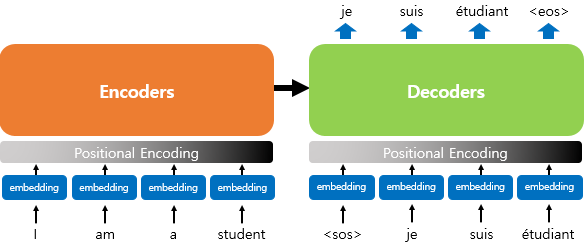

위의 그림은 입력으로 사용되는 임베딩 벡터들이 트랜스포머의 입력으로 사용되기 전에 포지셔널 인코딩값이 더해지는 것을 보여줍니다. 임베딩 벡터가 인코더의 입력으로 사용되기 전에 포지셔널 인코딩값이 더해지는 과정을 시각화하면 아래와 같습니다.

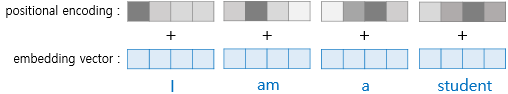

포지셔널 인코딩 값들은 어떤 값이기에 위치 정보를 반영해줄 수 있는 것일까요? 트랜스포머는 위치 정보를 가진 값을 만들기 위해서 아래의 두 개의 함수를 사용합니다.

$$PE_{(pos,\ 2i)}=sin(pos/10000^{2i/d_{model}})$$

$$PE_{(pos,\ 2i+1)}=cos(pos/10000^{2i/d_{model}})$$

사인 함수와 코사인 함수의 그래프를 상기해보면 요동치는 값의 형태를 생각해볼 수 있는데, 트랜스포머는 사인 함수와 코사인 함수의 값을 임베딩 벡터에 더해주므로서 단어의 순서 정보를 더하여 줍니다. 그런데 위의 두 함수에는 $pos, i, d_{model}$ 등의 생소한 변수들이 있습니다. 위의 함수를 이해하기 위해서는 위에서 본 임베딩 벡터와 포지셔널 인코딩의 덧셈은 사실 임베딩 벡터가 모여 만들어진 문장 벡터 행렬과 포지셔널 인코딩 행렬의 덧셈 연산을 통해 이루어진다는 점을 이해해야 합니다.

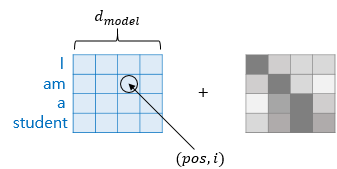

$pos$는 입력 문장에서의 임베딩 벡터의 위치를 나타내며, $i$는 임베딩 벡터 내의 차원의 인덱스를 의미합니다. 위의 식에 따르면 임베딩 벡터 내의 각 차원의 인덱스가 짝수인 경우에는 사인 함수의 값을 사용하고 홀수인 경우에는 코사인 함수의 값을 사용합니다. 위의 수식에서 $(pos,\ 2i)$일 때는 사인 함수를 사용하고, $(pos,\ 2i+1)$일 때는 코사인 함수를 사용하고 있음을 주목합시다.

또한 위의 식에서 $d_{model}$은 트랜스포머의 모든 층의 출력 차원을 의미하는 트랜스포머의 하이퍼파라미터입니다. 앞으로 보게 될 트랜스포머의 각종 구조에서 $d_{model}$의 값이 계속해서 등장하는 이유입니다. 임베딩 벡터 또한 $d_{model}$의 차원을 가지는데 위의 그림에서는 마치 4로 표현되었지만 실제 논문에서는 512의 값을 가집니다.

위와 같은 포지셔널 인코딩 방법을 사용하면 순서 정보가 보존되는데, 예를 들어 각 임베딩 벡터에 포지셔널 인코딩값을 더하면 같은 단어라고 하더라도 문장 내의 위치에 따라서 트랜스포머의 입력으로 들어가는 임베딩 벡터의 값이 달라집니다. 결국 트랜스포머의 입력은 순서 정보가 고려된 임베딩 벡터라고 보면 되겠습니다. 이를 코드로 구현하면 아래와 같습니다.

In [2]:
print(tf.range(5))
print(tf.range(1,5)[:, tf.newaxis])
print(tf.range(1,5)[tf.newaxis, :])

tf.Tensor([0 1 2 3 4], shape=(5,), dtype=int32)
tf.Tensor(
[[1]
 [2]
 [3]
 [4]], shape=(4, 1), dtype=int32)
tf.Tensor([[1 2 3 4]], shape=(1, 4), dtype=int32)


In [3]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super().__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
        
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles
    
    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis], # (position, 1)
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :], # (1, d_model)
            d_model=d_model)
        # angle_rads == (pos, d_model)
            
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        
        angle_rads = np.zeros(angle_rads.shape)
        angle_rads[:, 0::2] = sines
        angle_rads[:, 1::2] = cosines
        pos_encoding = tf.constant(angle_rads)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        print(pos_encoding.shape) # (1, position, 128)
        return tf.cast(pos_encoding, tf.float32)
    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :] # (1, None, 128)

50 × 128의 크기를 가지는 포지셔널 인코딩 행렬을 시각화하여 어떤 형태를 가지는지 확인해봅시다. 이는 입력 문장의 단어가 50개이면서, 각 단어가 128차원의 임베딩 벡터를 가질 때 사용할 수 있는 행렬입니다.

(1, 50, 128)


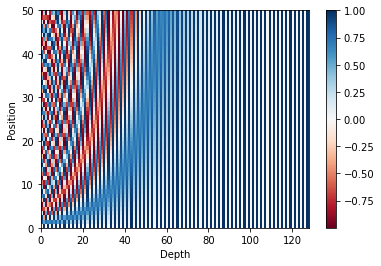

In [4]:
# 문장의 길이 50, 임베딩 벡터의 차원 128
sample_pos_encoding = PositionalEncoding(50, 128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap="RdBu")
plt.xlabel("Depth")
plt.xlim((0, 128))
plt.ylabel("Position")
plt.colorbar()
plt.show()

## 5. 어텐션(Attention)
트랜스포머에서 사용되는 세 가지의 어텐션에 대해서 간단히 정리해봅시다. 지금은 큰 그림을 이해하는 것에만 집중합니다.

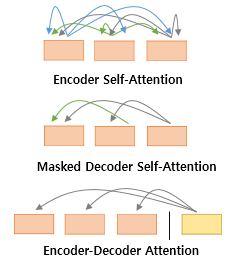

첫번째 그림인 셀프 어텐션은 인코더에서 이루어지지만, 두번째 그림인 셀프 어텐션과 세번째 그림인 인코더-디코더 어텐션은 디코더에서 이루어집니다. 셀프 어텐션은 본질적으로 Query, Key, Value가 동일한 경우를 말합니다. 반면, 세번째 그림 인코더-디코더 어텐션에서는 Query가 디코더의 벡터인 반면에 Key와 Value가 인코더의 벡터이므로 셀프 어텐션이라고 부르지 않습니다.

- 주의할 점은 여기서 Query, Key 등이 같다는 것은 벡터의 값이 같다는 것이 아니라 벡터의 출처가 같다는 의미입니다.

정리하면 다음과 같습니다.

```
인코더의 셀프 어텐션 : Query = Key = Value
디코더의 마스크드 셀프 어텐션 : Query = Key = Value
디코더의 인코더-디코더 어텐션 : Query : 디코더 벡터 / Key = Value : 인코더 벡터
```

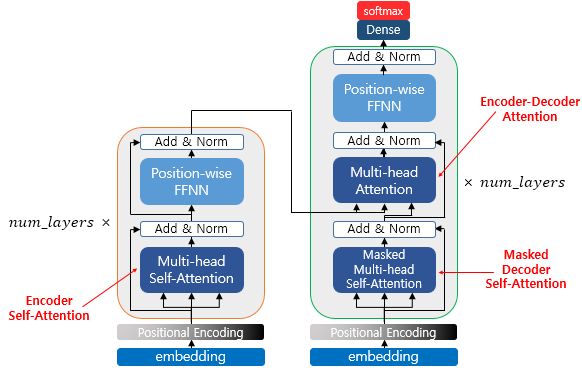

위 그림은 트랜스포머의 아키텍처에서 세 가지 어텐션이 각각 어디에서 이루어지는지를 보여줍니다. 세 개의 어텐션에 추가적으로 '멀티 헤드'라는 이름이 붙어있습니다. 뒤에서 설명하겠지만, 이는 트랜스포머가 어텐션을 병렬적으로 수행하는 방법을 의미합니다.

## 6. 인코더(Encoder)
인코더의 구조에 대해서 알아보겠습니다.

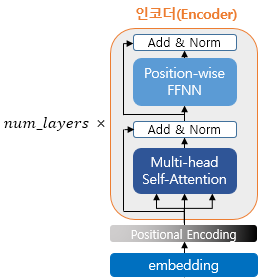

트랜스포머는 하이퍼파라미터인 $\text{num_layers}$ 개수의 인코더 층을 쌓습니다. 논문에서는 총 6개의 인코더 층을 사용하였습니다. 인코더를 하나의 층이라는 개념으로 생각한다면, 하나의 인코더 층은 크게 총 2개의 서브층(sublayer)으로 나뉘어집니다. 바로 셀프 어텐션과 피드 포워드 신경망입니다. 위의 그림에서는 멀티 헤드 셀프 어텐션과 포지션 와이즈 피드 포워드 신경망이라고 적혀있지만, 멀티 헤드 셀프 어텐션은 셀프 어텐션을 병렬적으로 사용하였다는 의미고, 포지션 와이즈 피드 포워드 신경망은 우리가 알고있는 일반적인 피드 포워드 신경망입니다. 우선 셀프 어텐션에 대해서 알아봅시다.

## 7. 인코더의 셀프 어텐션
트랜스포머에서는 셀프 어텐션이라는 어텐션 기법이 등장하는데 앞서 배웠던 어텐션 함수에 대해서 복습하고, 셀프 어텐션이 앞서 배웠던 어텐션과 무엇이 다른지 이해해보겠습니다.

### 1) 셀프 어텐션의 의미와 이점
어텐션 함수는 주어진 '쿼리(Query)'에 대해서 모든 '키(Key)'와의 유사도를 각각 구합니다. 그리고 구해낸 이 유사도를 가중치로 하여 키와 맵핑되어있는 각각의 '값(Value)'에 반영해줍니다. 그리고 유사도가 반영된 '값(Value)'을 모두 가중합하여 리턴합니다.

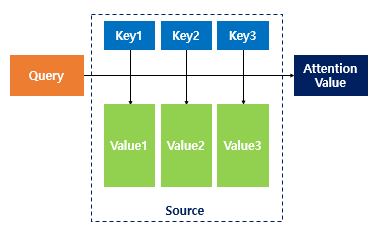

여기까지는 앞서 배운 어텐션의 개념입니다. 그런데 어텐션 중에서는 셀프 어텐션(self-attention)이라는 것이 있습니다. 단지 어텐션을 자기 자신에게 수행한다는 의미입니다. 앞서 배운 seq2seq에서 어텐션을 사용할 경우의 Q, K, V의 정의를 다시 생각해봅시다.

```
Q = Query : t 시점의 디코더 셀에서의 은닉 상태
K = Keys : 모든 시점의 인코더 셀의 은닉 상태들
V = Values : 모든 시점의 인코더 셀의 은닉 상태들
```

그런데 사실 t 시점이라는 것은 계속 변화하면서 반복적으로 쿼리를 수행하므로 결국 전체 시점에 대해서 일반화를 할 수도 있습니다.

```
Q = Querys : 모든 시점의 디코더 셀에서의 은닉 상태들
K = Keys : 모든 시점의 인코더 셀의 은닉 상태들
V = Values : 모든 시점의 인코더 셀의 은닉 상태들
```

이처럼 기존에는 디코더 셀의 은닉 상태가 Q이고 인코더 셀의 은닉 상태가 K라는 점에서 Q와 K가 서로 다른 값을 가지고 있었습니다. 그런데 셀프 어텐션에서는 Q, K, V가 전부 동일합니다. 트랜스포머의 셀프 어텐션에서의 Q, K, V는 아래와 같습니다.

```
Q : 입력 문장의 모든 단어 벡터들
K : 입력 문장의 모든 단어 벡터들
V : 입력 문장의 모든 단어 벡터들
```

셀프 어텐션에 대한 구체적인 사항을 배우기 전에 셀프 어텐션을 통해 얻을 수 있는 대표적인 효과에 대해서 이해해봅시다.

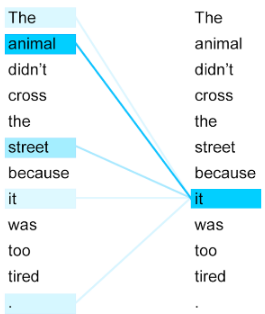

위의 그림은 트랜스포머에 대한 구글 AI 블로그 포스트에서 가져왔습니다. 위의 예시 문장을 번역하면 '그 동물은 길을 건너지 않았다. 왜냐하면 그것은 너무 피곤하였기 때문이다.' 라는 의미가 됩니다. 그런데 여기서 그것(it)에 해당하는 것은 과연 길(street)일까요? 동물(animal)일까요? 우리는 피곤한 주체가 동물이라는 것을 아주 쉽게 알 수 있지만 기계는 그렇지 않습니다. 하지만 셀프 어텐션은 입력 문장 내의 단어들끼리 유사도를 구하므로서 그것(it)이 동물(animal)과 연관되었을 확률이 높다는 것을 찾아냅니다.

이제 트랜스포머에서의 셀프 어텐션의 동작 메커니즘을 알아봅시다.

### 2) Q, K, V 벡터 얻기
앞서 셀프 어텐션은 입력 문장의 단어 벡터들을 가지고 수행한다고 하였는데, 사실 셀프 어텐션은 인코더의 초기 입력인 $d_{model}$의 차원을 가지는 단어 벡터들을 사용하여 셀프 어텐션을 수행하는 것이 아니라 우선 각 단어 벡터들로부터 Q벡터, K벡터, V벡터를 얻는 작업을 거칩니다. 이때 이 Q벡터, K벡터, V벡터들은 초기 입력인 $d_{model}$의 차원을 가지는 단어 벡터들보다 더 작은 차원을 가지는데, 논문에서는 $d_{model}$=512의 차원을 가졌던 각 단어 벡터들을 64의 차원을 가지는 Q벡터, K벡터, V벡터로 변환하였습니다.

64라는 값은 트랜스포머의 또 다른 하이퍼파라미터인 $\text{num_heads}$로 인해 결정되는데, 트랜스포머는 $d_{model}$을 $\text{num_heads}$로 나눈 값을 각 Q벡터, K벡터, V벡터의 차원으로 결정합니다. 논문에서는 $\text{num_heads}$를 8로하였습니다. 이제 그림을 통해 이해해봅시다. 예를 들어 여기서 사용하고 있는 예문 중 student라는 단어 벡터를 Q, K, V의 벡터로 변환하는 과정을 보겠습니다.

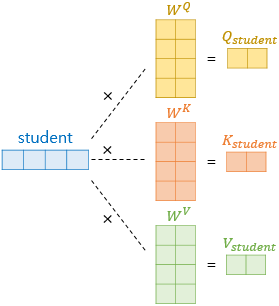

기존의 벡터로부터 더 작은 벡터는 가중치 행렬을 곱하므로서 완성됩니다. 각 가중치 행렬은 $d_{model} × (d_{model}\text{/num_heads})$의 크기를 가집니다. 이 가중치 행렬은 훈련 과정에서 학습됩니다. 즉, 논문과 같이 $d_{model}$=512이고 $\text{num_heads}$=8라면, 각 벡터에 3개의 서로 다른 가중치 행렬을 곱하고 64의 크기를 가지는 Q, K, V 벡터를 얻어냅니다. 위의 그림은 단어 벡터 중 student 벡터로부터 Q, K, V 벡터를 얻어내는 모습을 보여줍니다. 모든 단어 벡터에 위와 같은 과정을 거치면 I, am, a, student는 각각의 Q, K, V 벡터를 얻습니다.

### 3) 스케일드 닷-프로덕트 어텐션(Scaled dot-product Attention)
Q, K, V 벡터를 얻었다면 지금부터는 기존에 배운 어텐션 메커니즘과 동일합니다. 각 Q 벡터는 모든 K 벡터에 대해서 어텐션 스코어를 구하고, 어텐션 분포를 구한 뒤에 이를 사용하여 모든 V 벡터를 가중합하여 어텐션 값 또는 컨텍스트 벡터를 구하게 됩니다. 그리고 이를 모든 Q 벡터에 대해서 반복합니다.

그런데 앞서 어텐션 챕터에서 어텐션 함수의 종류는 다양하다고 언급한 바 있습니다. 트랜스포머에서는 어텐션 챕터에 사용했던 내적만을 사용하는 어텐션 함수 $score(q, k)=q⋅k$가 아니라 여기에 특정값으로 나눠준 어텐션 함수인 $score(q, k)=q⋅k/\sqrt{n}$를 사용합니다. 이러한 함수를 사용하는 어텐션을 어텐션 챕터에서 배운 닷-프로덕트 어텐션(dot-product attention)에서 값을 스케일링하는 것을 추가하였다고 하여 스케일드 닷-프로덕트 어텐션(Scaled dot-product Attention)이라고 합니다. 이제 그림을 통해 이해해봅시다.

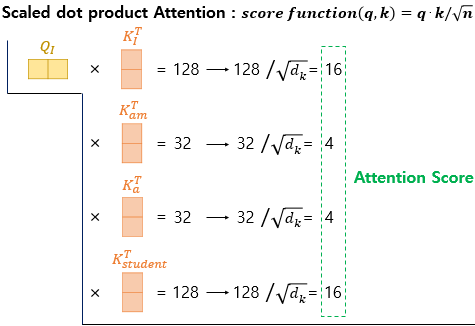

우선 단어 I에 대한 Q벡터를 기준으로 설명해보겠습니다. 지금부터 설명하는 과정은 am에 대한 Q벡터, a에 대한 Q벡터, student에 대한 Q벡터에 대해서도 모두 동일한 과정을 거칩니다. 위의 그림은 단어 I에 대한 Q 벡터가 모든 K 벡터에 대해서 어텐션 스코어를 구하는 것을 보여줍니다. 위의 128과 32는 저자가 임의로 가정한 수치로 신경쓰지 않아도 좋습니다.

위의 그림에서 어텐션 스코어는 각각 단어 I가 단어 I, am, a, student와 얼마나 연관되어 있는지를 보여주는 수치입니다. 트랜스포머에서는 두 벡터의 내적값을 스케일링하는 값으로 K 벡터의 차원을 나타내는 $d_{k}$에 루트를 씌운 $\sqrt{d_{k}}$ 사용하는 것을 택했습니다. 앞서 언급하였듯이 논문에서 $d_{k}$는 $d_{model}\text{/num_heads}$라는 식에 따라서 64의 값을 가지므로 $\sqrt{d_{k}}$는 8의 값을 가집니다.

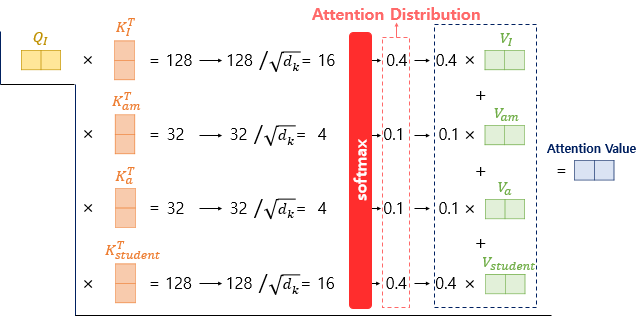

이제 어텐션 스코어에 소프트맥스 함수를 사용하여 어텐션 분포(Attention Distribution)을 구하고, 각 V 벡터와 가중합하여 어텐션 값(Attention Value)을 구합니다. 이를 단어 I에 대한 어텐션 값 또는 단어 I에 대한 컨텍스트 벡터(context vector)라고도 부릅니다. 이제 am에 대한 Q벡터, a에 대 Q벡터, student에 대한 Q벡터에 대해서도 모두 동일한 과정을 반복하여 각각에 대한 어텐션 값을 구합니다. 그런데 한 가지 의문이 남습니다. 굳이 이렇게 각 Q 벡터마다 일일히 따로 연산할 필요가 있을까요?

### 4) 행렬 연산으로 일괄 처리하기
사실 각 단어에 대한 Q, K, V 벡터를 구하고 스케일드 닷-프로덕트 어텐션을 수행하였던 위의 과정들은 벡터 연산이 아니라 행렬 연산을 사용하면 일괄 계산이 가능합니다. 지금까지 벡터 연산으로 설명하였던 이유는 이해를 돕기 위한 과정이고, 실제로는 행렬 연산으로 구현됩니다.

위의 과정을 벡터가 아닌 행렬 연산으로 이해해봅시다. 우선, 각 단어 벡터마다 일일히 가중치 행렬을 곱하는 것이 아니라 문장 행렬에 가중치 행렬을 곱하여 Q 행렬, K 행렬, V행렬을 구합니다.

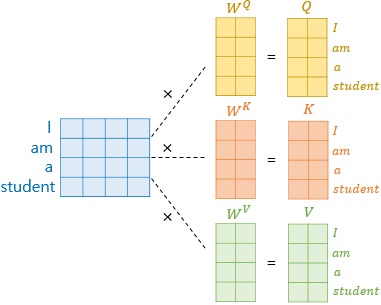

이제 행렬 연산을 통해 어텐션 스코어는 어떻게 구할 수 있을까요? 여기서 Q 행렬을 K 행렬을 전치한 행렬과 곱해준다고 해봅시다. 이렇게 되면 각각의 단어의 Q벡터와 K벡터의 내적이 각 행렬의 원소가 되는 행렬이 결과로 나옵니다.

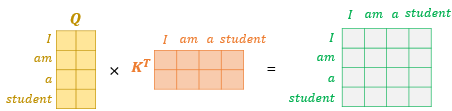

다시 말해 위의 그림의 결과 행렬의 값에 전체적으로 $\sqrt{d_{k}}$를 나누어주면 이는 각 행과 열이 어텐션 스코어값을 가지는 행렬이 됩니다. 예를 들어 I 행과 student 열의 값은 I의 Q벡터와 student의 K 벡터의 어텐션 스코어와 동일한 행렬이 된다는 것입니다. 즉, 어텐션 스코어 행렬입니다. 어텐션 스코어 행렬을 구하였다면 남은 것은 어텐션 분포를 구하고, 이를 사용하여 모든 단어에 대한 어텐션 값을 구하는 일입니다. 이는 간단하게 어텐션 스코어 행렬에 소프트맥스 함수를 사용하고, V 행렬을 곱하는 것으로 해결됩니다. 이렇게 되면 각 단어의 어텐션 값을 모두 가지는 어텐션 값 행렬이 결과로 나옵니다.

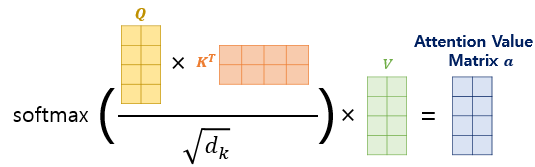

위의 그림은 행렬 연산을 통해 모든 값이 일괄 계산되는 과정을 식으로 보여줍니다. 해당 식은 실제 트랜스포머 논문에 기재된 아래의 수식과 정확하게 일치하는 식입니다.

$$Attention(Q, K, V) = softmax({QK^T\over{\sqrt{d_k}}})V$$

위의 행렬 연산에 사용된 행렬의 크기를 모두 정리해봅시다. 우선 입력 문장의 길이를 seq_len이라고 해봅시다. 그렇다면 문장 행렬의 크기는 $(\text{seq_len},\ d_{model})$입니다. 여기에 3개의 가중치 행렬을 곱해서 Q, K, V 행렬을 만들어야 합니다.

우선 행렬의 크기를 정의하기 위해 행렬의 각 행에 해당되는 Q 벡터와 K 벡터의 크기를 $d_{k}$라고 하고, V 벡터의 크기를 $d_{v}$라고 해봅시다. 그렇다면 Q 행렬과 K 행렬의 크기는 $(\text{seq_len},\ d_{k})$이며, V 행렬의 크기는 $(\text{seq_len},\ d_{v})$가 되어야 합니다. 그렇다면 문장 행렬과 Q, K, V 행렬의 크기로부터 가중치 행렬의 크기 추정이 가능합니다. $W^{Q}$와 $W^{K}$는 $(d_{model},\ d_{k})$의 크기를 가지며, $W^{V}$는 $(d_{model},\ d_{v})$의 크기를 가집니다. 단, 논문에서는 $d_{k}$와 $d_{v}$의 크기는 $d_{model}\text{/num_heads}$와 같습니다. 즉, $d_{model}\text{/num_heads}= d_{k}=d_{v}$입니다.

결과적으로 $softmax({QK^T\over{\sqrt{d_k}}})V$ 식을 적용하여 나오는 어텐션 값 행렬 $a$의 크기는 $(\text{seq_len},\ d_{v})$이 됩니다.

코드로 작성하면 아래와 같습니다.

### 5) 스케일드 닷-프로덕트 어텐션 구현하기

In [5]:
def scaled_dot_product_attention(query, key, value, mask):
    # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    # padding_mask : (batch_size, 1, 1, key의 문장 길이), logits과 shape을 맞춰주기 위해
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    
    # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
    # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
    if mask is not None:
        logits += (mask * -1e9)
        
    attention_weights = tf.nn.softmax(logits, axis=-1)
    output = tf.matmul(attention_weights, value)
    
    return output, attention_weights

코드는 위의 내용을 이해했다면 어렵지 않습니다. Q 행렬과 K 행렬을 전치한 행렬을 곱하고, 소프트맥스 함수를 사용하여 어텐션 분포 행렬을 얻은 뒤에 V 행렬과 곱합니다. 코드에서 mask가 사용되는 if문은 아직 배우지 않은 내용으로 지금은 무시하고 넘어갑니다.

scaled_dot_product_attention 함수가 정상 작동하는지 테스트를 해보겠습니다. 우선 temp_q, temp_k, temp_v라는 임의의 Query, Key, Value 행렬을 만들고, 이를 scaled_dot_product_attention 함수에 입력으로 넣어 함수가 리턴하는 값을 출력해볼 겁니다.

In [6]:
np.set_printoptions(suppress=True) # e-04와 같은 scientific notation을 제거

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)

여기서 주목할 점은 Query에 해당하는 temp_q의 값 [0, 10, 0]은 Key에 해당하는 temp_k의 두번째 값 [0, 10, 0]과 일치한다는 점입니다. 그렇다면 어텐션 분포와 어텐션 값은 과연 어떤 값이 나올까요?

In [7]:
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)

print(temp_out) # 어텐션 값
print(temp_attn) # 어텐션 분포(어텐션 가중치의 나열)

tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)


Query는 4개의 Key값 중 두번째 값과 일치하므로 어텐션 분포는 [0, 1, 0, 0]의 값을 가지며 결과적으로 Value의 두번째 값인 [10, 0]이 출력되는 것을 확인할 수 있습니다. 이번에는 Query의 값만 다른 값으로 바꿔보고 함수를 실행해봅시다. 이번에 사용할 Query값 [0, 0, 10]은 Key의 세번째 값과, 네번째 값 두 개의 값 모두와 일치하는 값입니다.

In [8]:
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포(어텐션 가중치의 나열)
print(temp_out) # 어텐션 값

tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


Query의 값은 Key의 세번째 값과 네번째 값 두 개의 값과 모두 유사하다는 의미에서 어텐션 분포는 [0, 0, 0.5, 0.5]의 값을 가집니다. 결과적으로 나오는 값 [550, 5.5]는 Value의 세번째 값 [100, 5]에 0.5를 곱한 값과 네번째 값 [1000, 6]에 0.5를 곱한 값의 원소별 합입니다. 이번에는 하나가 아닌 3개의 Query의 값을 함수의 입력으로 사용해보겠습니다.

In [9]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포(어텐션 가중치의 나열)
print(temp_out) # 어텐션 값

tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


### 6) 멀티 헤드 어텐션(Multi-head Attention)
앞서 배운 어텐션에서는 $d_{model}$의 차원을 가진 단어 벡터를 $\text{num_heads}$로 나눈 차원을 가지는 Q, K, V벡터로 바꾸고 어텐션을 수행하였습니다. 논문 기준으로는 512의 차원의 각 단어 벡터를 8로 나누어 64차원의 Q, K, V 벡터로 바꾸어서 어텐션을 수행한 셈인데, 이제 $\text{num_heads}$의 의미와 왜 $d_{model}$의 차원을 가진 단어 벡터를 가지고 어텐션을 하지 않고 차원을 축소시킨 벡터로 어텐션을 수행하였는지 이해해보겠습니다.

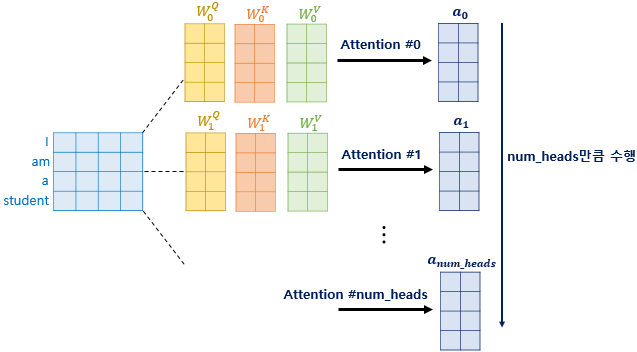

트랜스포머 연구진은 한 번의 어텐션을 하는 것보다 여러번의 어텐션을 병렬로 사용하는 것이 더 효과적이라고 판단하였습니다. 그래서 $d_{model}$의 차원을 $\text{num_heads}$개로 나누어 $d_{model}\text{/num_heads}$의 차원을 가지는 Q, K, V에 대해서 $\text{num_heads}$개의 병렬 어텐션을 수행합니다. 논문에서는 하이퍼파라미터인 $\text{num_heads}$의 값을 8로 지정하였고, 8개의 병렬 어텐션이 이루어지게 됩니다. 다시 말해 위에서 설명한 어텐션이 8개로 병렬로 이루어지게 되는데, 이때 각각의 어텐션 값 행렬을 어텐션 헤드라고 부릅니다. 이때 가중치 행렬 $W^{Q}, W^{K}, W^{V}$의 값은 8개의 어텐션 헤드마다 전부 다릅니다.

병렬 어텐션으로 얻을 수 있는 효과는 무엇일까요? 그리스로마신화에는 머리가 여러 개인 괴물 히드라나 케로베로스가 나옵니다. 이 괴물들의 특징은 머리가 여러 개이기 때문에 여러 시점에서 상대방을 볼 수 있다는 겁니다. 이렇게 되면 시각에서 놓치는 게 별로 없을테니까 이런 괴물들에게 기습을 하는 것이 굉장히 힘이 들겁니다. 멀티 헤드 어텐션도 똑같습니다. 어텐션을 병렬로 수행하여 다른 시각으로 정보들을 수집하겠다는 겁니다.

예를 들어보겠습니다. 앞서 사용한 예문 '그 동물은 길을 건너지 않았다. 왜냐하면 그것은 너무 피곤하였기 때문이다.'를 상기해봅시다. 단어 그것(it)이 쿼리였다고 해봅시다. 즉, it에 대한 Q벡터로부터 다른 단어와의 연관도를 구하였을 때 첫번째 어텐션 헤드는 '그것(it)'과 '동물(animal)'의 연관도를 높게 본다면, 두번째 어텐션 헤드는 '그것(it)'과 '피곤하였기 때문이다(tired)'의 연관도를 높게 볼 수 있습니다. 각 어텐션 헤드는 전부 다른 시각에서 보고있기 때문입니다.

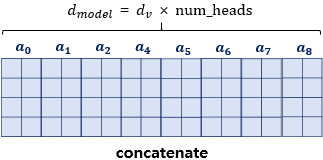

병렬 어텐션을 모두 수행하였다면 모든 어텐션 헤드를 연결(concatenate)합니다. 모두 연결된 어텐션 헤드 행렬의 크기는 $(\text{seq_len},\ d_{model})$가 됩니다.

지금까지 그림에서는 책의 지면상의 한계로 4차원을 $d_{model}$=512로 표현하고, 2차원을 $d_{v}$=64로 표현해왔기 때문에 위의 그림의 행렬의 크기에 혼동의 있을 수 있으나 8개의 어텐션 헤드의 연결(concatenate) 과정의 이해를 위해 이번 행렬만 예외로 위와 같이 $d_{model}$의 크기를 $d_{v}$의 8배인 16차원으로 표현하였습니다. 아래의 그림에서는 다시 $d_{model}$를 4차원으로 표현합니다.

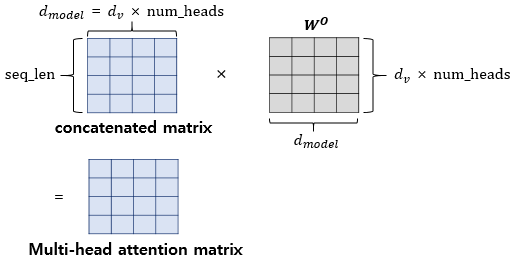

어텐션 헤드를 모두 연결한 행렬은 또 다른 가중치 행렬 $W^{o}$을 곱하게 되는데, 이렇게 나온 결과 행렬이 멀티-헤드 어텐션의 최종 결과물입니다. 위의 그림은 어텐션 헤드를 모두 연결한 행렬이 가중치 행렬 $W^{o}$과 곱해지는 과정을 보여줍니다. 이때 결과물인 멀티-헤드 어텐션 행렬은 인코더의 입력이었던 문장 행렬의 $(\text{seq_len},\ d_{model})$ 크기와 동일합니다.

다시 말해 인코더의 첫번째 서브층인 멀티-헤드 어텐션 단계를 끝마쳤을 때, 인코더의 입력으로 들어왔던 행렬의 크기가 아직 유지되고 있음을 기억해둡시다. 첫번째 서브층인 멀티-헤드 어텐션과 두번째 서브층인 포지션 와이즈 피드 포워드 신경망을 지나면서 인코더의 입력으로 들어올 때의 행렬의 크기는 계속 유지되어야 합니다. 트랜스포머는 다수의 인코더를 쌓은 형태인데(논문에서는 인코더가 6개), 인코더에서의 입력의 크기가 출력에서도 동일 크기로 계속 유지되어야만 다음 인코더에서도 다시 입력이 될 수 있기 때문입니다.

### 7) 멀티 헤드 어텐션(Multi-head Attention) 구현하기
멀티 헤드 어텐션에서는 크 게 두 종류의 가중치 행렬이 나왔습니다. 바로 Q, K, V 행렬을 만들기 위한 가중치 행렬인 WQ, WK, WV 행렬과 바로 어텐션 헤드들을 연결(concatenation) 후에 곱해주는 WO 행렬입니다. 가중치 행렬을 곱하는 것을 구현 상에서는 입력을 밀집층(Dense layer)를 지나게 하므로서 구현합니다. 케라스 코드 상으로 지금까지 줄기차게 사용해왔던 Dense()에 해당됩니다.

```python
Dense(units)
```

멀티 헤드 어텐션의 구현은 크게 다섯 가지 파트로 구성됩니다.

    1. WQ, WK, WV에 해당하는 d_model 크기의 밀집층(Dense layer)을 지나게한다.
    2. 지정된 헤드 수(num_heads)만큼 나눈다(split).
    3. 스케일드 닷 프로덕트 어텐션.
    4. 나눠졌던 헤드들을 연결(concatenatetion)한다.
    5. WO에 해당하는 밀집층을 지나게 한다.

이론으로 설명할 때보다 심플하게 구성되었는데 결국 근본적으로 동일한 내용입니다.

In [10]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super().__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0 # d_model % self.num_heads == 0가 아니면 에러를 띄움
        
        self.depth = d_model // self.num_heads
        
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)
        
        # WO에 해당하는 밀집층 정의
        self.dense = tf.keras.layers.Dense(units=d_model)
    
    # num_heads 개수만큼 q, k, v를 split하는 함수
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs,
                            shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])
    
    def call(self, inputs):
        query, key, value, mask = inputs["query"], inputs["key"], inputs["value"], inputs["mask"]
        batch_size = tf.shape(query)[0]
        
        # 1. WQ, WK, WV에 해당하는 밀집층 지나기
        # q : (batch_size, query의 문장 길이, d_model)
        # k : (batch_size, key의 문장 길이, d_model)
        # v : (batch_size, value의 문장 길이, d_model)
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
        
        
         # 2. 헤드 나누기
        # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
        # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        
        # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
        # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
        # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        # 4. 헤드 연결(concatenate)하기
        # (batch_size, query의 문장 길이, d_model)
        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))
        
        # 5. WO에 해당하는 밀집층 지나기
        # (batch_size, query의 문장 길이, d_model)
        outputs = self.dense(concat_attention)
        outputs = self.dense(concat_attention)

        return outputs

멀티 헤드 어텐션 함수를 구현해보았습니다. 이제 딱 한 가지만 더 설명하고, 두번째 서브층에 대한 설명으로 넘어가봅시다.

### 8) 패딩 마스크(Padding Mask)
아직 설명하지 않은 내용이 있습니다. 앞서 구현한 스케일드 닷 프로덕트 어텐션 함수 내부를 보면 mask라는 값을 인자로 받아서, 이 mask값에다가 -1e9라는 아주 작은 음수값을 곱한 후 어텐션 스코어 행렬에 더해주고 있습니다. 이 연산의 정체는 무엇일까요?

```python
def scaled_dot_product_attention(query, key, value, mask):
... 중략 ...
    logits += (mask * -1e9) # 어텐션 스코어 행렬인 logits에 mask*-1e9 값을 더해주고 있다.
... 중략 ...
```

이는 입력 문장에 $<PAD>$ 토큰이 있을 경우 어텐션에서 사실상 제외하기 위한 연산입니다. 예를 들어 $<PAD>$가 포함된 입력 문장의 셀프 어텐션의 예제를 봅시다. 이에 대해서 어텐션을 수행하고 어텐션 스코어 행렬을 얻는 과정은 다음과 같습니다.
    
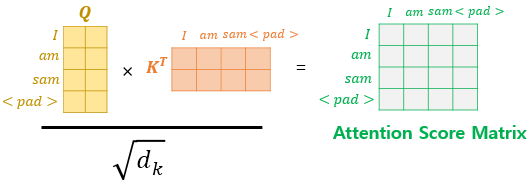
    
그런데 사실 단어 $<PAD>$의 경우에는 실질적인 의미를 가진 단어가 아닙니다. 그래서 트랜스포머에서는 Key의 경우에 $<PAD>$ 토큰이 존재한다면 이에 대해서는 유사도를 구하지 않도록 마스킹(Masking)을 해주기로 했습니다. 여기서 마스킹이란 어텐션에서 제외하기 위해 값을 가린다는 의미입니다. 어텐션 스코어 행렬에서 행에 해당하는 문장은 Query이고, 열에 해당하는 문장은 Key입니다. 그리고 Key에 $<PAD>$가 있는 경우에는 해당 열 전체를 마스킹을 해줍니다.

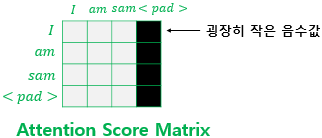

마스킹을 하는 방법은 어텐션 스코어 행렬의 마스킹 위치에 매우 작은 음수값을 넣어주는 것입니다. 여기서 매우 작은 음수값이라는 것은 -1,000,000,000과 같은 -무한대에 가까운 수라는 의미입니다. 현재 어텐션 스코어 함수는 소프트맥스 함수를 지나지 않은 상태입니다. 앞서 배운 연산 순서라면 어텐션 스코어 함수는 소프트맥스 함수를 지나고, 그 후 Value 행렬과 곱해지게 됩니다. 그런데 현재 마스킹 위치에 매우 작은 음수 값이 들어가 있으므로 어텐션 스코어 행렬이 소프트맥스 함수를 지난 후에는 해당 위치의 값은 0에 굉장히 가까운 값이 되어 단어 간 유사도를 구하는 일에 <PAD> 토큰이 반영되지 않게 됩니다.

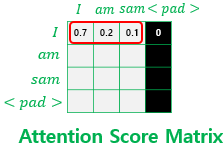

패딩 마스크를 구현하는 방법은 입력된 정수 시퀀스에서 패딩 토큰의 인덱스인지, 아닌지를 판별하는 함수를 구현하는 것입니다. 아래의 함수는 정수 시퀀스에서 0인 경우에는 1로 변환하고, 그렇지 않은 경우에는 0으로 변환하는 함수입니다.

In [6]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, key의 문장 길이)
    return mask[:, tf.newaxis, tf.newaxis, :]

임의의 정수 시퀀스 입력을 넣어서 어떻게 변환되는지 보겠습니다.

In [12]:
print(create_padding_mask(tf.constant([[1, 21, 777, 0, 0]])))

tf.Tensor([[[[0. 0. 0. 1. 1.]]]], shape=(1, 1, 1, 5), dtype=float32)


위 벡터를 통해서 1의 값을 가진 위치의 열을 어텐션 스코어 행렬에서 마스킹하는 용도로 사용할 수 있습니다. 위 벡터를 스케일드 닷 프로덕트 어텐션의 인자로 전달하면, 스케일드 닷 프로덕트 어텐션에서는 위 벡터에다가 매우 작은 음수값인 -1e9를 곱하고, 이를 행렬에 더해주어 해당 열을 전부 마스킹하게 되는 것입니다.

첫번째 서브층인 멀티 헤드 어텐션을 구현해보았습니다. 앞서 인코더는 두 개의 서브 서브층(sublayer)으로 나뉘어진다고 언급한 적이 있는데, 이제 두번째 서브층인 포지션-와이즈 피드 포워드 신경망에 대해서 알아보겠습니다.

## 8. 포지션-와이즈 피드 포워드 신경망(Position-wise FFNN)
지금은 인코더를 설명하고 있지만, 포지션 와이즈 FFNN은 인코더와 디코더에서 공통적으로 가지고 있는 서브층입니다. 포지션-와이즈 FFNN는 쉽게 말하면 완전 연결 FFNN(Fully-connected FFNN)이라고 해석할 수 있습니다. 앞서 인공 신경망은 결국 벡터와 행렬 연산으로 표현될 수 있음을 배웠습니다. 아래는 포지션 와이즈 FFNN의 수식을 보여줍니다.

$FFNN(x) = MAX(0, x{W_{1}} + b_{1}){W_2} + b_2$

식을 그림으로 표현하면 아래와 같습니다.

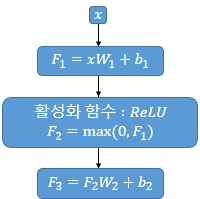

 여기서 $x$는 앞서 멀티 헤드 어텐션의 결과로 나온 $(\text{seq_len},\ d_{model})$의 크기를 가지는 행렬을 말합니다. 가중치 행렬 $W_{1}$은 $(d_{model},\ d_{ff})$의 크기를 가지고, 가중치 행렬 $W_{2}$은 $(d_{ff},\ d_{model})$의 크기를 가집니다. 논문에서 은닉층의 크기인 $d_{ff}$는 앞서 하이퍼파라미터를 정의할 때 언급했듯이 2,048의 크기를 가집니다.

여기서 매개변수 $W_1, b_1, W_2, b_2$는 하나의 인코더 층 내에서는 다른 문장, 다른 단어들마다 정확하게 동일하게 사용됩니다. 하지만 인코더 층마다는 다른 값을 가집니다.

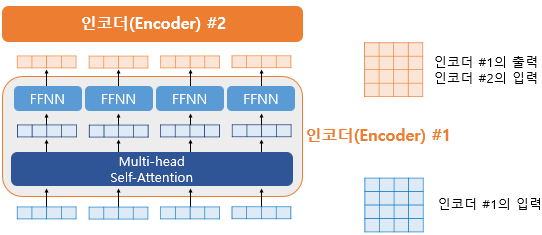

위의 그림에서 좌측은 인코더의 입력을 벡터 단위로 봤을 때, 각 벡터들이 멀티 헤드 어텐션 층이라는 인코더 내 첫번째 서브 층을 지나 FFNN을 통과하는 것을 보여줍니다. 이는 두번째 서브층인 Position-wise FFNN을 의미합니다. 물론, 실제로는 그림의 우측과 같이 행렬로 연산되는데, 두번째 서브층을 지난 인코더의 최종 출력은 여전히 인코더의 입력의 크기였던 $(\text{seq_len},\ d_{model})$의 크기가 보존되고 있습니다. 하나의 인코더 층을 지난 이 행렬은 다음 인코더 층으로 전달되고, 다음 층에서도 동일한 인코더 연산이 반복됩니다.

이를 구현하면 다음과 같습니다.

```python
# 다음의 코드는 인코더와 디코더 내부에서 사용할 예정입니다.
outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
outputs = tf.keras.layers.Dense(units=d_model)(outputs)
```

## 9. 잔차 연결(Residual connection)과 층 정규화(Layer Normalization)

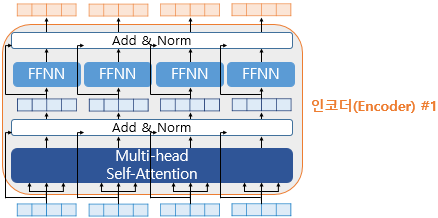

인코더의 두 개의 서브층에 대해서 이해하였다면 인코더에 대한 설명은 거의 다왔습니다! 트랜스포머에서는 이러한 두 개의 서브층을 가진 인코더에 추가적으로 사용하는 기법이 있는데, 바로 Add & Norm입니다. 더 정확히는 잔차 연결(residual connection)과 층 정규화(layer normalization)를 의미합니다.

위의 그림은 앞서 Position-wise FFNN를 설명할 때 사용한 앞선 그림에서 화살표와 Add & Norm(잔차 연결과 정규화 과정)을 추가한 그림입니다. 추가된 화살표들은 서브층 이전의 입력에서 시작되어 서브층의 출력 부분을 향하고 있는 것에 주목합시다. 추가된 화살표가 어떤 의미를 갖고 있는지는 잔차 연결과 층 정규화를 배우고 나면 이해할 수 있습니다.

### 1) 잔차 연결(Residual connection)
잔차 연결(residual connection)의 의미를 이해하기 위해서 어떤 함수 $H(x)$에 대한 이야기를 해보겠습니다.

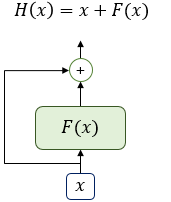

위 그림은 입력 $x$와 $x$에 대한 어떤 함수 $F(x)$의 값을 더한 함수 $H(x)$의 구조를 보여줍니다. 어떤 함수 $F(x)$가 트랜스포머에서는 서브층에 해당됩니다. 다시 말해 잔차 연결은 서브층의 입력과 출력을 더하는 것을 말합니다. 앞서 언급했듯이 트랜스포머에서 서브층의 입력과 출력은 동일한 차원을 갖고 있으므로, 서브층의 입력과 서브층의 출력은 덧셈 연산을 할 수 있습니다. 이것이 바로 위의 인코더 그림에서 각 화살표가 서브층의 입력에서 출력으로 향하도록 그려졌던 이유입니다. 잔차 연결은 컴퓨터 비전 분야에서 주로 사용되는 모델의 학습을 돕는 기법입니다.

이를 식으로 표현하면 $x+Sublayer(x)$라고 할 수 있습니다.

가령, 서브층이 멀티 헤드 어텐션이었다면 잔차 연결 연산은 다음과 같습니다.

$H(x) = x+Multi\_head\ Attention(x)$

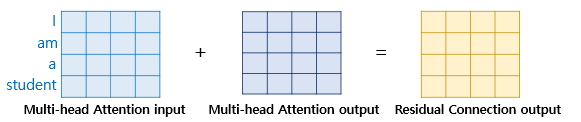

위 그림은 멀티 헤드 어텐션의 입력과 멀티 헤드 어텐션의 결과가 더해지는 과정을 보여줍니다.

관련 논문 : https://arxiv.org/pdf/1512.03385.pdf


### 2) 층 정규화(Layer Normalization)
잔차 연결을 거친 결과는 이어서 층 정규화 과정을 거치게됩니다. 잔차 연결의 입력을 $x$, 잔차 연결과 층 정규화 두 가지 연산을 모두 수행한 후의 결과 행렬을 $LN$이라고 하였을 때, 잔차 연결 후 층 정규화 연산을 수식으로 표현하자면 다음과 같습니다.

$LN = LayerNorm(x+Sublayer(x))$

이제 층 정규화를 하는 과정에 대해서 이해해봅시다. **층 정규화는 텐서의 마지막 차원**에 대해서 평균과 분산을 구하고, 이를 가지고 어떤 수식을 통해 값을 정규화하여 학습을 돕습니다. 여기서 텐서의 마지막 차원이란 것은 트랜스포머에서는 $d_{model}$ 차원을 의미합니다. 아래 그림은 $d_{model}$ 차원의 방향을 화살표로 표현하였습니다.

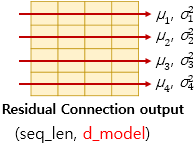

층 정규화를 위해서 우선, 화살표 방향으로 각각 평균 $μ$과 분산 $σ^{2}$을 구합니다. 각 화살표 방향의 벡터를 $x_{i}$라고 명명해봅시다.

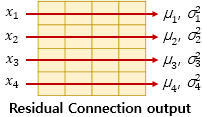

층 정규화를 수행한 후에는 벡터 $x_{i}$는 $ln_{i}$라는 벡터로 정규화가 됩니다.

$ln_{i} = LayerNorm(x_{i})$

이제 층 정규화의 수식을 알아봅시다. 여기서는 층 정규화를 두 가지 과정으로 나누어서 설명하겠습니다. 첫번째는 평균과 분산을 통한 정규화, 두번째는 감마와 베타를 도입하는 것입니다. 우선, 평균과 분산을 통해 벡터 $x_{i}$를 정규화 해줍니다. $x_{i}$는 벡터인 반면, 평균 $μ_{i}$과 분산 $σ^{2}_{i}$은 스칼라입니다. 벡터 $x_{i}$의 각 차원을 라고 하였을 때, $x_{i,k}$는 다음의 수식과 같이 정규화 할 수 있습니다. 다시 말해 벡터 $x_{i}$의 각 차원의 값이 다음과 같이 정규화 되는 것입니다.

$$\hat{x}_{i, k} = \frac{x_{i, k}-μ_{i}}{\sqrt{σ^{2}_{i}+\epsilon}}$$

$ϵ$(입실론)은 분모가 0이 되는 것을 방지하는 값입니다.

이제 $γ$(감마)와 $β$(베타)라는 벡터를 준비합니다. 단, 이들의 초기값은 각각 1과 0입니다.

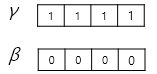

$γ$와 $β$를 도입한 층 정규화의 최종 수식은 다음과 같으며, $γ$와 $β$는 학습 가능한 파라미터입니다.

$$ln_{i} = γ\hat{x}_{i}+β = LayerNorm(x_{i})$$

관련 논문 : https://arxiv.org/pdf/1607.06450.pdf

케라스에서는 LayerNormalization()를 이미 제공하고 있으므로, 이를 가져와 사용합니다.

## 10. 인코더 구현하기
지금까지 배운 내용을 바탕으로 인코더를 구현한 코드는 다음과 같습니다.

In [13]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    
    # 인코더는 패딩 마스크 사용
    padding_mask =  tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    
    # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
    attention = MultiHeadAttention(d_model, num_heads, name="attention")({
        "query": inputs, "key":inputs, "value": inputs, "mask": padding_mask
    })
    
    # 드롭아웃 + 잔차 연결과 층 정규화
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)
    
    # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
    outputs = tf.keras.layers.Dense(units=dff, activation="relu")(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    # 드롭아웃 + 잔차 연결과 층 정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)
    
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

우선 인코더의 입력으로 들어가는 문장에는 패딩이 있을 수 있으므로, 어텐션 시 패딩 토큰을 제외하도록 패딩 마스크를 사용합니다. 이는 MultiHeadAttention 함수의 mask의 인자값으로 padding_mask가 들어가는 이유입니다. 인코더는 총 두 개의 서브층으로 이루어지는데, 멀티 헤드 어텐션과 피드 포워드 신경망입니다. 각 서브층 이후에는 드롭 아웃, 잔차 연결과 층 정규화가 수행됩니다.

위 코드는 하나의 인코더 블록. 즉, 하나의 인코더 층을 구현하는 코드입니다. 물론, 실제로 트랜스포머는 num_layers 개수만큼의 인코더 층을 사용하므로 이를 여러번 쌓는 코드를 별도 구현해줄 필요가 있습니다.

## 11. 인코더 쌓기
지금까지 인코더 층의 내부 아키텍처에 대해서 이해해보았습니다. 이러한 인코더 층을 num_layers개만큼 쌓고, 마지막 인코더 층에서 얻는 (seq_len, d_model) 크기의 행렬을 디코더로 보내주므로서 트랜스포머 인코더의 인코딩 연산이 끝나게 됩니다. 아래의 코드는 인코더 층을 num_layers개만큼 쌓는 코드입니다.

In [14]:
def encoder(vocab_size, num_layers, dff, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    
    # 인코더는 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    
    # 포지셔널 인코딩 + 드롭아웃
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    # 인코더를 num_layers개 쌓기
    for i in range(num_layers):
        outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
                                dropout=dropout, name=f"encoder_layer_{i}")([outputs, padding_mask])
        
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

## 12. 인코더에서 디코더로(From Encoder To Decoder)

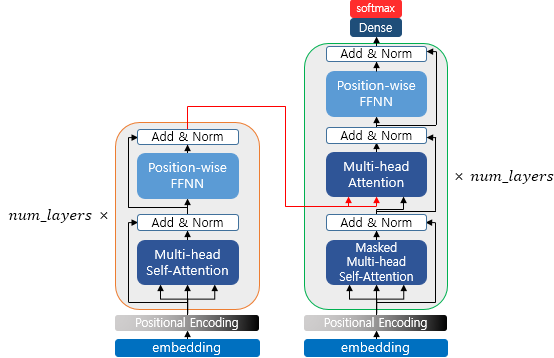

지금까지 인코더에 대해서 정리해보았습니다. 이렇게 구현된 인코더는 총 $\text{num_layers}$만큼의 층 연산을 순차적으로 한 후에 마지막 층의 인코더의 출력을 디코더에게 전달합니다. 인코더 연산이 끝났으므로 이제 디코더 연산이 시작되어 디코더 또한 총 $\text{num_layers}$만큼의 연산을 하는데, 이때마다 인코더가 보낸 출력을 각 디코더 층 연산에 사용합니다. 이제 본격적으로 **디코더**에 대해서 이해해봅시다.

## 13. 디코더의 첫번째 서브층 : 셀프 어텐션과 룩-어헤드 마스크

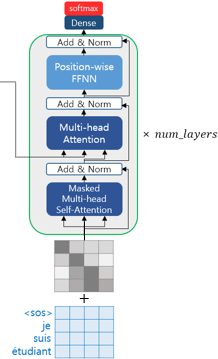

위 그림과 같이 디코더도 인코더와 동일하게 임베딩 층과 포지셔널 인코딩을 거친 후의 문장 행렬이 입력됩니다. 트랜스포머 또한 seq2seq와 마찬가지로 교사 강요(Teacher Forcing)을 사용하여 훈련되므로 학습 과정에서 디코더는 번역할 문장에 해당되는 <sos> je suis étudiant의 문장 행렬을 한 번에 입력받습니다. 그리고 디코더는 이 문장 행렬로부터 각 시점의 단어를 예측하도록 훈련됩니다.

여기서 문제가 있습니다. seq2seq의 디코더에 사용되는 RNN 계열의 신경망은 입력 단어를 매 시점마다 순차적으로 받으므로 다음 단어 예측에 현재 시점 이전 이전에 입력된 단어들만 참고할 수 있습니다. 반면, 트랜스포머는 문장 행렬로 입력을 한 번에 받으므로 현재 시점의 단어를 예측하고자 할 때, 입력 문장 행렬로부터 미래 시점의 단어까지도 참고할 수 있는 현상이 발생합니다. 가령, suis를 예측해야 하는 시점이라고 해봅시다. seq2seq의 디코더라면 현재까지 디코더에 입력된 단어는 <sos>와 je뿐일 것입니다. 반면, 트랜스포머는 이미 문장 행렬로 <sos> je suis étudiant를 입력받았습니다.

이를 위해 트랜스포머의 디코더에서는 현재 시점의 예측에서 현재 시점보다 미래에 있는 단어들을 참고하지 못하도록 룩-어헤드 마스크(look-ahead mask)를 도입했습니다. 직역하면 '미리보기에 대한 마스크'라고 할 수 있습니다.

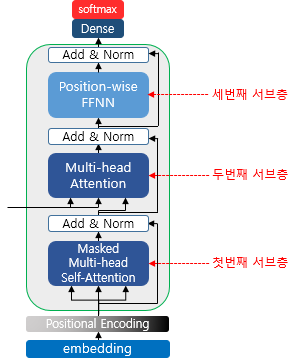

룩-어헤드 마스크(look-ahead mask)는 디코더의 첫번째 서브층에서 이루어집니다. 디코더의 첫번째 서브층인 멀티 헤드 셀프 어텐션 층은 인코더의 첫번째 서브층인 멀티 헤드 셀프 어텐션 층과 동일한 연산을 수행합니다. 오직, 다른 점은 어텐션 스코어 행렬에서 마스킹을 적용한다는 점만 다릅니다. 우선, 다음과 같이 셀프 어텐션을 통해 어텐션 스코어 행렬을 얻습니다.

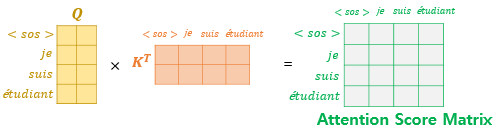

이제 자기 자신보다 미래에 있는 단어들은 참고하지 못하도록 다음과 같이 마스킹합니다.

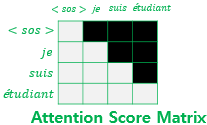

마스킹 된 후의 어텐션 스코어 행렬의 각 행을 보면 자기 자신과 그 이전 단어들만을 참고할 수 있음을 볼 수 있습니다. 그 외에는 근본적으로 셀프 어텐션이라는 점과, 멀티 헤드 어텐션을 수행한다는 점에서 인코더의 첫번째 서브층과 같습니다.

룩-어헤드 마스크의 구현에 대해 알아봅시다. 룩-어헤드 마스크는 패딩 마스크와 마찬가지로 앞서 구현한 스케일드 닷 프로덕트 어텐션 함수에 mask라는 인자로 전달됩니다. 패딩 마스킹을 써야하는 경우에는 스케일드 닷 프로덕트 어텐션 함수에 패딩 마스크를 전달하고, 룩-어헤드 마스킹을 써야하는 경우에는 스케일드 닷 프로덕트 어텐션 함수에 룩-어헤드 마스크를 전달하게 됩니다.

```python
# 스케일드 닷 프로덕트 어텐션 함수를 다시 복습해봅시다.
def scaled_dot_product_attention(query, key, value, mask):
... 중략 ...
    logits += (mask * -1e9) # 어텐션 스코어 행렬인 logits에 mask*-1e9 값을 더해주고 있다.
... 중략 ...
```

트랜스포머에는 총 세 가지 어텐션이 존재하며, 모두 멀티 헤드 어텐션을 수행하고, 멀티 헤드 어텐션 함수 내부에서 스케일드 닷 프로덕트 어텐션 함수를 호출하는데 각 어텐션 시 함수에 전달하는 마스킹은 다음과 같습니다.

- 인코더의 셀프 어텐션 : 패딩 마스크를 전달
- 디코더의 첫번째 서브층인 마스크드 셀프 어텐션 : 룩-어헤드 마스크를 전달 <-- 지금 배우고 있음.
- 디코더의 두번째 서브층인 인코더-디코더 어텐션 : 패딩 마스크를 전달

이때, 룩-어헤드 마스크를 한다고해서 패딩 마스크가 불필요한 것이 아니므로 룩-어헤드 마스크는 패딩 마스크를 포함하도록 구현합니다. 룩-어헤드 마스크를 구현하는 방법은 패딩 마스크 때와 마찬가지로 마스킹을 하고자 하는 위치에는 1을, 마스킹을 하지 않는 위치에는 0을 리턴하도록 합니다.

In [9]:
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 Mask하는 함수
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
# tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0) 
# ==
# tf.Tensor(
# [[1. 0. 0. 0. 0.]
#  [1. 1. 0. 0. 0.]
#  [1. 1. 1. 0. 0.]
#  [1. 1. 1. 1. 0.]
#  [1. 1. 1. 1. 1.]], shape=(5, 5), dtype=float32)
# (5, 5)
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    print(look_ahead_mask)
    padding_mask = create_padding_mask(x)
    print(padding_mask)
    return tf.maximum(look_ahead_mask, padding_mask)

임의의 정수 시퀀스 입력을 넣어서 결과를 봅시다. 패딩 마스크를 테스트 하기위해 세번째 위치에 정수 0을 넣었습니다.

In [10]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]], shape=(5, 5), dtype=float32)
tf.Tensor([[[[0. 0. 1. 0. 0.]]]], shape=(1, 1, 1, 5), dtype=float32)
tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


룩-어헤드 마스크이므로 삼각형 모양의 마스킹이 형성되면서, 패딩 마스크가 포함되어져 있으므로 세번째 열이 마스킹되었습니다.

## 14. 디코더의 두번째 서브층 : 인코더-디코더 어텐션
디코더의 두번째 서브층에 대해서 이해해봅시다. 디코더의 두번째 서브층은 멀티 헤드 어텐션을 수행한다는 점에서는 이전의 어텐션들(인코더와 디코더의 첫번째 서브층)과 같지만, 셀프 어텐션은 아닙니다.

셀프 어텐션은 Query, Key, Value가 같은 경우를 말하는데, 인코더-디코더 어텐션은 Query가 디코더인 행렬인 반면, Key와 Value는 인코더 행렬이기 때문입니다. 다시 한 번 각 서브층에서의 Q, K, V의 관계를 정리해봅시다.

```
인코더의 첫번째 서브층 : Query = Key = Value
디코더의 첫번째 서브층 : Query = Key = Value
디코더의 두번째 서브층 : Query : 디코더 행렬 / Key = Value : 인코더 행렬
```

디코더의 두번째 서브층을 확대해보면, 다음과 같이 인코더로부터 두 개의 화살표가 그려져 있습니다.

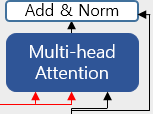

두 개의 화살표는 각각 Key와 Value를 의미하며, 이는 인코더의 마지막 층에서 온 행렬로부터 얻습니다. 반면, Query는 디코더의 첫번째 서브층의 결과 행렬로부터 얻는다는 점이 다릅니다. Query가 디코더 행렬, Key가 인코더 행렬일 때, 어텐션 스코어 행렬을 구하는 과정은 다음과 같습니다.

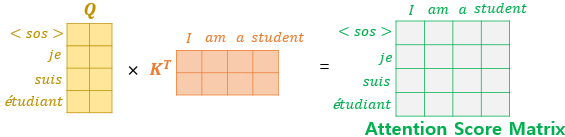

그 외에 멀티 헤드 어텐션을 수행하는 과정은 다른 어텐션들과 같습니다.

## 15. 디코더 구현하기

In [17]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    
    # 룩어헤드 마스크(첫번째 서브층)
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    
    # 패딩 마스크(두번째 서브층)
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    
    # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
    attention1 = MultiHeadAttention(d_model, num_heads, name="attention_1")(inputs={
        "query": inputs, "key": inputs, "value": inputs, "mask": look_ahead_mask
    })
    
    # 잔차 연결과 층 정규화
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)
    
    # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
    attention2 = MultiHeadAttention(d_model, num_heads, name="attention_2")(inputs={
        "query": attention1, "key": enc_outputs, "value": enc_outputs,
        "mask": padding_mask
    })
    
    # 드롭아웃 + 잔차 연결과 층 정규화
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)
    
    # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
    outputs = tf.keras.layers.Dense(units=dff, activation="relu")(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    # 드롭아웃 + 잔차 연결과 층 정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)
    
    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
                          outputs=outputs,
                          name=name)

디코더는 총 세 개의 서브층으로 구성됩니다. 첫번째와 두번째 서브층 모두 멀티 헤드 어텐션이지만, 첫번째 서브층은 mask의 인자값으로 look_ahead_mask가 들어가는 반면, 두번째 서브층은 mask의 인자값으로 padding_mask가 들어가는 것을 확인할 수 있습니다. 이는 첫번째 서브층은 마스크드 셀프 어텐션을 수행하기 때문입니다. 세 개의 서브층 모두 서브층 연산 후에는 드롭 아웃, 잔차 연결, 층 정규화가 수행되는 것을 확인할 수 있습니다.

인코더와 마찬가지로 디코더도 num_layers개만큼 쌓는 코드가 필요합니다. 아래를 보겠습니다.

## 16. 디코더 쌓기

In [18]:
def decoder(vocab_size, num_layers, dff, d_model, num_heads, dropout, name="decoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    
    # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    
    # 포지셔널 인코딩 + 드롭아웃
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    # 디코더를 num_layers개 쌓기
    for i in range(num_layers):
        outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
                                dropout=dropout, 
                                name=f"decoder_layer_{i}")(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])
    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name
    )

## 17. 트랜스포머 구현하기
이제 지금까지 구현한 인코더와 디코더 함수를 조합하여 트랜스포머를 조립할 차례입니다. 인코더의 출력은 디코더에서 인코더-디코더 어텐션에서 사용되기 위해 디코더로 전달해줍니다. 그리고 디코더의 끝단에는 다중 클래스 분류 문제를 풀 수 있도록, vocab_size 만큼의 뉴런을 가지는 신경망을 추가해줍니다.

In [19]:
def transformer(vocab_size, num_layers, dff, d_model, num_heads, dropout, name="transformer"):
    # 인코더의 입력
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    
    # 디코더의 입력
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")
    
    # 인코더의 패딩 마스크
    enc_padding_mask = tf.keras.layers.Lambda(create_pading_mask, output_shape=(1, 1, None),
                                              name="enc_padding_mask")(inputs)
    
    # 디코더의 룩어헤드 마스크(첫번째 서브층)
    look_ahead_mask = tf.keras.layers.Lambda(create_look_ahead_mask, output_shape=(1, None, None),
                                             name="look_ahead_mask")(dec_inputs)
    
    # 디코더의 패딩 마스크(두번째 서브층)
    dec_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None),
                                              name="dec_padding_mask")(inputs)
    
    # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
    enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
                          d_model=d_model, num_heads=num_heads, 
                          dropout=dropout)(inputs=[inputs, enc_padding_mask])
    
    # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
    dec_outputs =decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
                         d_model=d_model, num_heads=num_heads, 
                         dropout=dropout)(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])
    
    # 다음 단어 예측을 위한 출력층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)
    
    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

## 18. 트랜스포머 하이퍼파라미터 정하기
이제 트랜스포머의 하이퍼파라미터를 임의로 정하고, 모델을 만들어봅시다. 현재 훈련 데이터가 존재하는 것은 아니지만, 단어 집합의 크기는 임의로 9,000으로 정합니다. 단어 집합의 크기로부터 룩업 테이블을 수행할 임베딩 테이블과 포지셔널 인코딩 행렬의 행의 크기를 결정할 수 있습니다.

여기서는 논문에서 제시한 것과는 조금 다르게 하이퍼파라미터를 정해보겠습니다. 인코더와 디코더의 층의 개수 $\text{num_layers}$는 4개, 인코더와 디코더의 포지션 와이즈 피드 포워드 신경망의 은닉층 $d_{ff}$은 128, 인코더와 디코더의 입, 출력의 차원 $d_{model}$은 128, 멀티-헤드 어텐션에서 병렬적으로 사용할 헤드의 수 $\text{num_heads}$는 4로 정했습니다. 이렇게 되면 128/4의 값인 32가 $d_{v}$의 값이 되겠습니다.

In [20]:
# !pip install pydot
# !pip install graphviz

In [21]:
# import os
# os.environ["PATH"] = os.environ["PATH"] + os.pathsep + "C/Program Files (x86)/Graphviz2.38/bin"

(1, 9000, 128)
(1, 9000, 128)


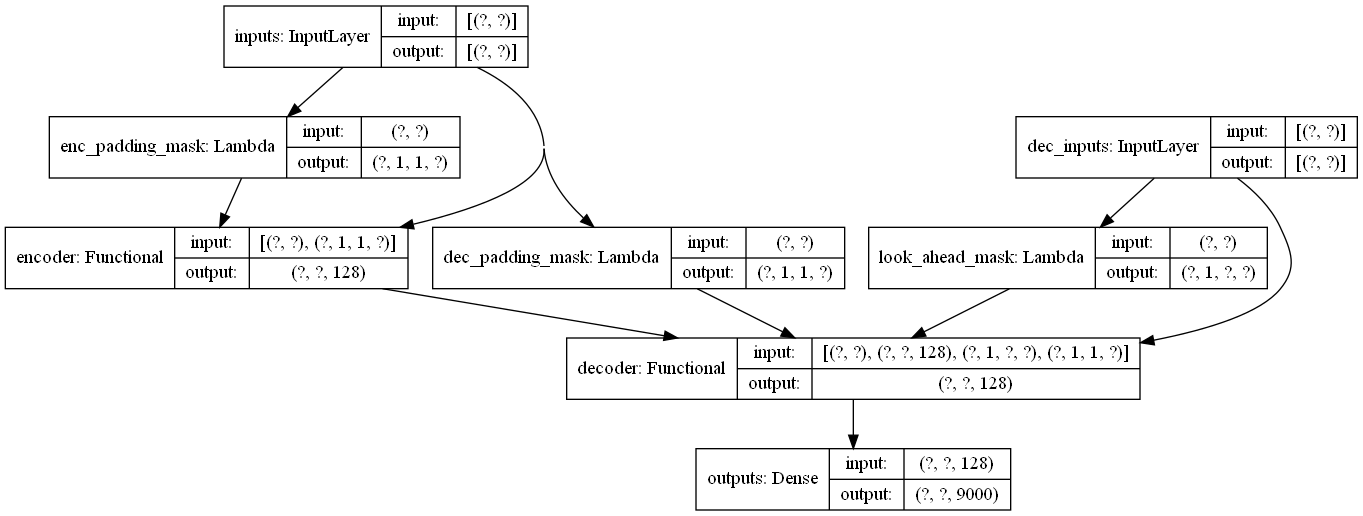

In [22]:
small_transformer = transformer(
    vocab_size=9000,
    num_layers=4,
    dff=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="small_transformer"
)

tf.keras.utils.plot_model(small_transformer, to_file="small_transformer.png",
                          show_shapes=True)

## 19. 손실 함수 정의하기
다중 클래스 분류 문제를 풀 예정이므로 크로스 엔트로피 함수를 손실 함수로 정의합니다.

In [24]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction="none")(y_true, y_pred) 
    # 클래스 분류 문제에서 softmax 함수를 거치면 from_logits = False(default값), 그렇지 않으면 from_logits = True
    # reduction="none" == https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy
    # (차원을 줄이지 않음)
    
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)
    
    return tf.reduce_mean(loss)

## 20. 학습률
트랜스포머의 경우 학습률(learning rate)은 고정된 값을 유지하는 것이 아니라, 학습 경과에 따라 변하도록 설계하였습니다. 아래의 공식으로 학습률을 계산하여 사용하였으며, warmup_steps의 값으로는 4,000을 사용하였습니다.

$\Large{lrate = d_{model}^{-0.5} × min(\text{step_num}^{-0.5},\ \text{step_num} × \text{warmup_steps}^{-1.5})}$

In [28]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step) # 제곱근의 역수
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

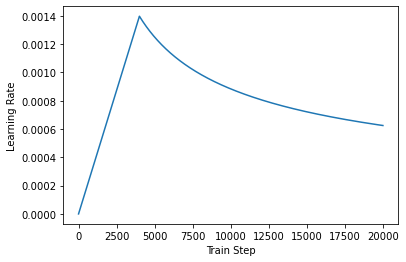

In [29]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(20000., dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

이제 여기서 구현한 트랜스포머 모델을 바탕으로 다음 챕터에서 이어서 챗봇을 만들어보겠습니다.

---------------
논문에서는 언급되지 않은 트랜스포머의 구현 이야기 : https://tunz.kr/post/4